In [1]:
import numpy as np
import matplotlib.pyplot as plt

import string
import copy
import itertools

from models import ContinuousIncrementalRSA
from utils import *
import time
from tqdm import tqdm

import scipy.stats

## Fig. 1a: Vary the informativeness of the adjective by manipulating semantic values

In [2]:
semantic_value_range = np.linspace(0.5, 1, num=11)
adjectives = [c for c in string.ascii_lowercase[:13]]
nouns = [c for c in string.ascii_lowercase[13:]]
objects = get_all_objects(adjectives, nouns)
utterances = get_all_utterances(adjectives, nouns)

In [3]:
all_probs = []
for num_adj in range(2, 6):
    for num_noun in [3]:
        print('num adjectives', num_adj, 'num nouns', num_noun)
        
        adj_subset = adjectives[:num_adj]
        noun_subset = nouns[:num_noun]
        
        objects = get_all_objects(adj_subset, noun_subset)
        utterances = get_all_utterances(adj_subset, noun_subset)
        
        probs = np.zeros(shape=(len(semantic_value_range), len(semantic_value_range)))
        for i in range(len(semantic_value_range)):
            for j in range(len(semantic_value_range)):
                v_adj = semantic_value_range[i]
                v_noun = semantic_value_range[j]

                rsa = ContinuousIncrementalRSA(adj_subset, noun_subset, objects, utterances, v_adj=v_adj, v_noun=v_noun)
                p_adj_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'a n')
                p_noun_first = rsa.incremental_pragmatic_speaker({'color': 'a', 'shape': 'n', 'string': 'a n'}, 'n a')

                normalized_p_adj_first = p_adj_first / (p_adj_first + p_noun_first)
                normalized_p_noun_first = p_noun_first / (p_adj_first + p_noun_first)
                probs[i, j] = normalized_p_noun_first

        all_probs.append(probs)

num adjectives 2 num nouns 3


/Users/dharakyu/Documents/word-ordering/models.py:113: RuntimeWarning: divide by zero encountered in log
  val = np.exp(self.alpha * (np.log(utility) - self.cost(curr_utt)))
/Users/dharakyu/Documents/word-ordering/models.py:25: RuntimeWarning: invalid value encountered in true_divide
  return matrix / totals[:, np.newaxis]


num adjectives 3 num nouns 3
num adjectives 4 num nouns 3
num adjectives 5 num nouns 3


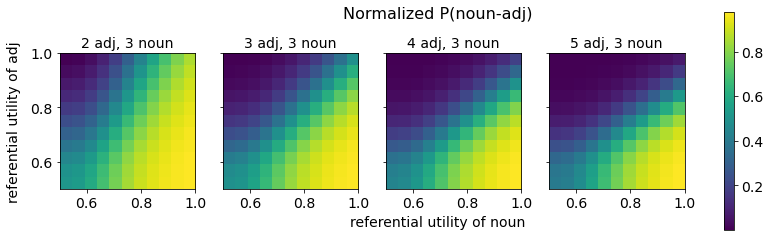

In [32]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(14, 4))
for i, ax in enumerate(axs):
    im = ax.imshow(all_probs[i], origin='lower', extent=[0.5, 1, 0.5, 1])
    ax.set_title(str(i+2)+" adj, 3 noun", fontsize=14)
    ax.tick_params(labelsize=14)

fig.suptitle('Normalized P(noun-adj)', x=0.5, y=0.9, size=16)

fig.text(0.5, 0.15, "referential utility of noun", ha="center", va="center", fontsize=14)
fig.text(0.08, 0.5, "referential utility of adj", ha="center", va="center", rotation=90, fontsize=14)
cbar = plt.colorbar(im, ax=axs)
cbar.ax.tick_params(labelsize=14)
plt.savefig('semantic_values.png')

## Fig. 1b: Vary the informativeness of the adjective by manipulating the number of duplicates

Assume fixed semantic values $v_{\text{adj}} = 0.9, v_{\text{noun}} = 0.95$

In [5]:
adjectives = ["red", "blue", "green"]
nouns = ["pin", "dress", "truck"]
objects = get_all_objects(adjectives, nouns)
utterances = get_all_utterances(adjectives, nouns)
objects

[{'color': 'red', 'shape': 'pin', 'string': 'red pin'},
 {'color': 'red', 'shape': 'dress', 'string': 'red dress'},
 {'color': 'red', 'shape': 'truck', 'string': 'red truck'},
 {'color': 'blue', 'shape': 'pin', 'string': 'blue pin'},
 {'color': 'blue', 'shape': 'dress', 'string': 'blue dress'},
 {'color': 'blue', 'shape': 'truck', 'string': 'blue truck'},
 {'color': 'green', 'shape': 'pin', 'string': 'green pin'},
 {'color': 'green', 'shape': 'dress', 'string': 'green dress'},
 {'color': 'green', 'shape': 'truck', 'string': 'green truck'}]

In [6]:
objs_to_visualize = [{'color': 'red', 'shape': 'pin', 'string': 'red pin'},
                     {'color': 'blue', 'shape': 'pin', 'string': 'blue pin'},
                     {'color': 'red', 'shape': 'dress', 'string': 'red dress'},
                     {'color': 'green', 'shape': 'truck', 'string': 'green truck'}
                    ]
obj_names = [obj['string'] for obj in objs_to_visualize]
max_num_duplicates = 5
num_utt_types = 2
probs_map = {obj: np.zeros(shape=(max_num_duplicates, num_utt_types)) for obj in obj_names}
probs_map

{'red pin': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'blue pin': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'red dress': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'green truck': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

In [7]:
for dup_idx in range(max_num_duplicates):
    objects_copy = copy.deepcopy(objects)
    for _ in range(dup_idx):
        objects_copy.append({'color': 'red', 'shape': 'pin', 'string': 'red pin'})
    print('Num duplicates', dup_idx)
    rsa = ContinuousIncrementalRSA(adjectives=adjectives,
                                    nouns=nouns,
                                    objects=objects_copy,
                                    utterances=utterances,
                                )
    
    for obj_idx, obj in enumerate(objs_to_visualize):
        tokens = [obj['color'], obj['shape']]
        options = list(itertools.permutations(tokens))

        for utt_idx, option in enumerate(options):
            utt = " ".join(option)
            #print(utt)
            p = rsa.incremental_pragmatic_speaker(obj, utt)
            #print(p)
            probs_map[obj['string']][dup_idx][utt_idx] = p

Num duplicates 0
Num duplicates 1
Num duplicates 2
Num duplicates 3
Num duplicates 4


In [8]:
probs_map

{'red pin': array([[0.39939628, 0.59474946],
        [0.4123912 , 0.55372507],
        [0.40991236, 0.51472985],
        [0.4008375 , 0.48078901],
        [0.389797  , 0.45253989]]),
 'blue pin': array([[0.39939628, 0.59474946],
        [0.71420359, 0.28144066],
        [0.8709885 , 0.12361111],
        [0.93525714, 0.05822636],
        [0.96229084, 0.03013005]]),
 'red dress': array([[0.39939628, 0.59474946],
        [0.15402608, 0.83991307],
        [0.06134419, 0.93193643],
        [0.02730101, 0.96556845],
        [0.01349777, 0.9790777 ]]),
 'green truck': array([[0.39939628, 0.59474946],
        [0.38472878, 0.60956988],
        [0.37052011, 0.62391382],
        [0.35677453, 0.63777964],
        [0.3434933 , 0.65116829]])}

In [9]:
normalized_probs_map = {}
for key, val in probs_map.items():
    normalized_val = np.sum(val, axis=1)
    normalized_val = normalized_val[:, np.newaxis]
    normalized_probs = val / normalized_val
    normalized_probs_map[key] = normalized_probs

/var/folders/wh/tk6j12kd7jq5djbxfn93wjdm0000gn/T/ipykernel_94234/1689814288.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  row_ax.set_xticklabels(x_labels, rotation=60)


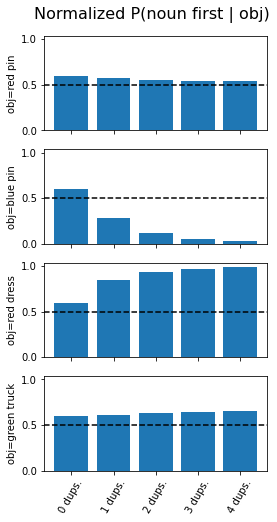

In [10]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(4, 8))
for obj_idx, row_ax in enumerate(axs):
    obj_name = obj_names[obj_idx]
    vals_for_hist = normalized_probs_map[obj_name][:, -1]
    x_labels = [str(i) + ' dups.' for i in range(5)]
    row_ax.bar(x_labels, vals_for_hist)
    row_ax.axhline(y=0.5, ls='--', c='black', zorder=1)
    row_ax.set_xticklabels(x_labels, rotation=60)
    row_ax.set_ylabel("obj=" + obj_name)
fig.suptitle('Normalized P(noun first | obj)', fontsize=16, x=0.5, y=0.93)
plt.savefig('duplicates.png')